# AMOC EWS under multiplicative noise


## Import libraries


In [1]:
# Start timer to record execution time of notebook
import time
start_time = time.time()

In [2]:
import numpy as np
np.random.seed(0) # Set seed for reproducibility
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import Image

import ewstools

## Run AMOC model

Before computing EWS, it is necessary to set up your data inside a [`TimeSeries`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries) object. Your data must be a 1D time series and can take the form of a python list, a numpy array, or a pandas series. In the case of a pandas series, the index of your data will be carried forward throughout the analysis, which is preferable if you don't want arbitrary time points assigned.


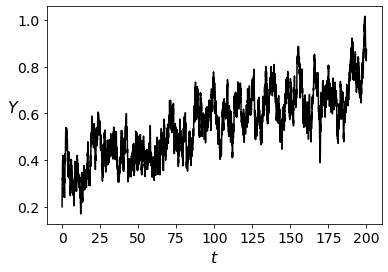

In [3]:
plotvar = [1]
F0 = 0.6; mu = 1.5; sigmaA = 0.1; Xzero = 0.2
T=200; N=10000; dt = float(T)/N; dF = 0.25
sigmaM = 0.0; 
t=np.linspace(0,T,N+1)

dW=np.sqrt(dt)*np.random.randn(1,N)
W=np.cumsum(dW)

Xem=np.zeros(N+1); Xem[0] = Xzero
F = np.zeros(N+1)

for j in range(1,N+1):
    Winc=np.sum(dW[0][range(j-1,j)])
    F[j] = F0 + j*dF/N
    Xem[j]=Xem[j-1]+dt*(F[j]-Xem[j-1]*(1+mu*(1-Xem[j-1])**2))+(sigmaA+sigmaM*Xem[j-1])*Winc

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(t,Xem,color='black')
plt.xlabel(r'$t$',fontsize=16); 
plt.ylabel(r'$Y$',fontsize=16,rotation=0)
#if plotvar == 1:
#plt.savefig('../paper/figs/model_time_series.png',bbox_inches='tight')
plt.show()

In [4]:
series = pd.Series(data=Xem, index=t)
series.index.name='time'

In [5]:
type(series)

pandas.core.series.Series

Alongside the data, there is the option to specify a transtion time, beyond which any EWS will not be computed. Based on the plot, let's take a conservative transition time of 80. There exist methods to estimate transition times such as change-point detection algorithms, which can be implemented using the Python package [ruptures](https://github.com/deepcharles/ruptures).

In [6]:
# Create TimeSeries object
# ts = ewstools.TimeSeries(data=series, transition=95)
ts = ewstools.TimeSeries(data=series)

The [`TimeSeries`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries) object has several attributes worth knowing about:

| Attribute | Type | Notes |
| :- | :- | :- |
| `transition`  | float | transition time (if defined) | 
| `state`  | pd.DataFrame | dataframe containing raw time series data and any detrending | 
| `ews`  | pd.DataFrame | dataframe containing any EWS computed | 
| `ktau`  | dict | dictionary containing Kendall tau values | 
| `dl_preds`  | pd.DataFrame | dataframe containing predictions from deep learning classifiers | 

You can access these attributes by writing `TimeSeries.attribute`.

In [7]:
# E.g. check the defined transtion time
ts.transition

To begin with, these attributes should all be empty, except for `transition` (if defined) and `state`, where you should see your data. Let's check out the head of the `state` DataFrame.

In [8]:
ts.state.head()

state
time          
0.00  0.200000
0.02  0.229108
0.04  0.238101
0.06  0.255036
0.08  0.289382

We can plot it using the pandas function `.plot()`

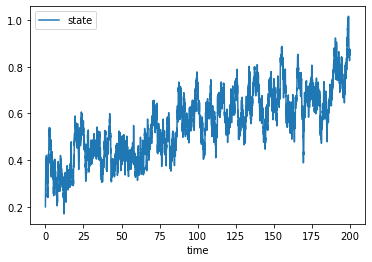

In [9]:
ts.state.plot();

## Detrend the data (if necessary)

Data can be detrended in *ewstools* with [`.detrend()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.detrend). Current options include a Gaussian or a Lowess filter. You'll need to select a bandwidth (for Gaussian) or a span (for Lowess). Considerations to make when choosing appropriate detrending parameters are given in [Dakos et al. (2012)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0041010). You can define your bandwidth/span as either an absolute number of data points, or a proportion of the number of data points prior to the transition.

Let's detrend our data using a Lowess filter with a span of 0.2. After doing so, we should find that the attribute `state` contains the smoothed time series and residuals.

In [10]:
ts.detrend(method='Lowess', span=0.2)
ts.state.head()

state  smoothing  residuals
time                                
0.00  0.200000   0.308788  -0.108788
0.02  0.229108   0.308872  -0.079764
0.04  0.238101   0.308956  -0.070855
0.06  0.255036   0.309041  -0.054005
0.08  0.289382   0.309125  -0.019743

Which we can plot as follows:

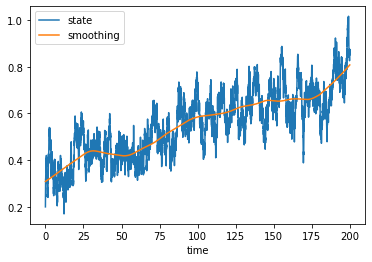

In [11]:
ts.state[['state','smoothing']].plot();

## Compute CSD-based early warning signals (EWS)

There are many time series metrics that can indicate critical slowing down (CSD), thus providing a warning for a bifurcation. We refer to these metrics as CSD-based EWS. They are computed over a rolling window with a size defined by the user. The rolling window can be given as a proporiton of the pre-transition data, or an absolute number of data points. If you chose to detrend, EWS will be computed on the residual data. Otherwise, EWS will be computed on the raw data.

The table below lists the CSD-based EWS that can be computed by *ewstools* and their associated method:

| EWS  | Method | Notes |
| ------------- | ------------- | -------------- |
| variance  | [`compute_var()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_var)  | Second moment of the data |
| standard deviation | [`compute_std()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_std) | Square root of the variance |
| coefficient of variation | [`compute_cv()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_cv) | Standard deviation divided by the mean (of the undetrended time series) | 
| skewness | [`compute_skew()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_skew)  | Standardised third moment of the data |
| kurtosis | [`compute_kurt()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_kurt)  | Standardised fourth moment of the data |
| lag-tau autocorrelation | [`compute_auto(lag=tau)`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_auto)  | Correlation between the data and a shifted version (by tau) of itself |

There also exist EWS based on the power spectrum of a time series, however we have saved these for a later tutorial as they require the extra step of computing the power spectrum. Let's compute the variance, coefficient of variation, lag-1 autocorrelation and skew of our residual data prior to the fold bifurcation:

In [12]:
# Define rolling window length
rw = 0.5
ts.compute_var(rolling_window=rw)
ts.compute_cv(rolling_window=rw)
ts.compute_auto(rolling_window=rw, lag=1)
ts.compute_skew(rolling_window=rw)

This will fill up the `ews` attribute of the TimeSeries object.

In [13]:
ts.ews.dropna().head()

variance        cv       ac1      skew
time                                          
99.98   0.004904  0.154788  0.980014  0.391720
100.00  0.004906  0.154773  0.980038  0.391867
100.02  0.004908  0.154780  0.980051  0.391664
100.04  0.004910  0.154782  0.980065  0.391183
100.06  0.004912  0.154777  0.980088  0.390405

## Measure the trend of the EWS with Kendall tau

For this time series, we see roughly increasing trends in the EWS as a result of the critical slowing down phenomena. A useful way to measure the increasing/decreasing tendancy of a trend, is to compute the Kendall tau correlation between the signal and time. Kendall tau values can be computed with the method [`compute_ktau()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_ktau).

In [14]:
ts.compute_ktau()

Now the `ktau` attribute should be filled with the Kendall tau value for each EWS computed.

In [15]:
ts.ktau

{'variance': 0.7065474550032017,
 'cv': -0.6731642875743125,
 'ac1': 0.689601304049466,
 'skew': -0.756041914368026}

The positive values indicate increasing trends. Negative values would indicate decreasing trends. A maximal (minimal) Kendall tau value of 1 (-1) indicates that every subsequent point takes a larger (smaller) value.

## Visualise output of *ewstools*

Output can be visualised with the method [`make_plotly()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.make_plotly), which creates an interactive figure in [Plotly](https://plotly.com/) of all the EWS that have been computed.

In [16]:
fig = ts.make_plotly(kendall_tau=True)
fig.show()
#Image(fig.to_image()) # use the command fig.show() if running a Jupyter notebook to view the interactive version

If running a script, the figure can be exported to an html file and viewed in a web browser, with the Plotly method `fig.write_html(filepath)`.

Alternatively, it's straightforward to make your own plot directly in matplotlib.

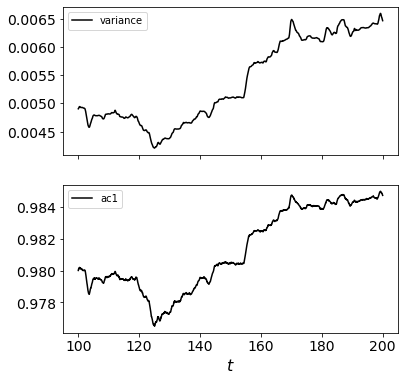

In [17]:
fig1, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,6), sharex=True)
#ts.state[['state','smoothing']].plot(ax=axes[0])
ts.ews['variance'].plot(ax=axes[0],legend=True,fontsize=14,color='black')
ts.ews['ac1'].plot(ax=axes[1],legend=True,fontsize=14,color='black');
plt.xlabel(r'$t$',fontsize=16);
#ts.ews['skew'].plot(ax=axes[2],legend=True);
#if plotvar == 1:
#plt.savefig('../paper/figs/ews.png',bbox_inches='tight')

Statistical Significance

In [18]:
import pymannkendall as mk
data=ts.ews.dropna().loc[:,'variance']
print(data)
mk.original_test(data)

time
99.98     0.004904
100.00    0.004906
100.02    0.004908
100.04    0.004910
100.06    0.004912
            ...   
199.92    0.006480
199.94    0.006477
199.96    0.006473
199.98    0.006470
200.00    0.006466
Name: variance, Length: 5002, dtype: float64


Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=74.92943718091344, Tau=0.7065474550032017, s=8837143.0, var_s=13909730834.333334, slope=4.5874138935235e-07, intercept=0.003953274959539529)

In [19]:
import pymannkendall as mk
data=ts.ews.dropna().loc[:,'ac1']
print(data)
mk.original_test(data)

time
99.98     0.980014
100.00    0.980038
100.02    0.980051
100.04    0.980065
100.06    0.980088
            ...   
199.92    0.984777
199.94    0.984771
199.96    0.984761
199.98    0.984752
200.00    0.984739
Name: ac1, Length: 5002, dtype: float64


Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=73.13229576027729, Tau=0.689601304049466, s=8625189.0, var_s=13909730834.333334, slope=1.4905493806588173e-06, intercept=0.9767296306768612)

In [20]:
# Stop timer
end_time = time.time()
print('Notebook took {:.1f}s to run'.format(end_time-start_time))

Notebook took 42.7s to run
